# **Sentiment Analysis on Movie Reviews**

For this project I was required to develop a natural language processing (NLP) model to perform sentiment analysis on movie reviews. The model should classify
reviews as positive or negative.

In [1]:
# !pip install wordcloud

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')
# !pip install contractions
# nltk.download('stopwords')
# nltk.download('punkt')
# import spacy
import contractions
from collections import Counter
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [31]:
# load the dataset
df = pd.read_csv('IMDB Dataset.csv')

In [33]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [35]:
# view the dataset
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

# Data Exploration

In [38]:
# shape of the data
df.shape

(50000, 2)

In [40]:
# check the infor
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [42]:
# desribe dataset
df.describe().T

count unique                                                top  \
review     50000  49582  Loved today's show!!! It was a variety and not...   
sentiment  50000      2                                           positive   

            freq  
review         5  
sentiment  25000

In [44]:
# sentiment count
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

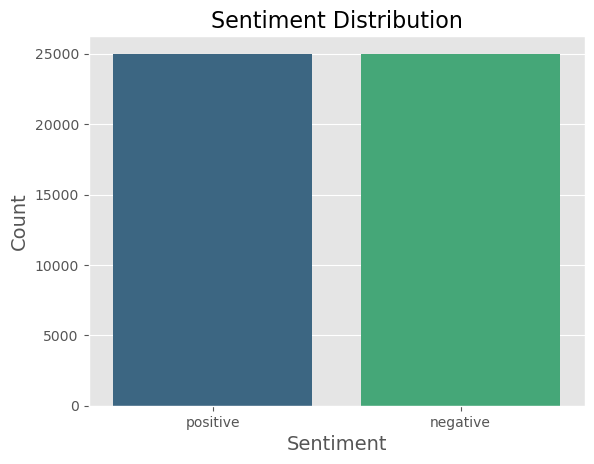

In [46]:
# check the distribution of the dataset using countplot
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [48]:
for i in range(5):
  print("Review: ", [i])
  print(df['review'].iloc[i], "\n")
  print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [50]:
# getting the nummber of words per sentiment
def word_count(text):
  return len(text.split())

# apply the function here
df['word count'] = df['review'].apply(word_count)
df.head()

review sentiment  word count
0  One of the other reviewers has mentioned that ...  positive         307
1  A wonderful little production. <br /><br />The...  positive         162
2  I thought this was a wonderful way to spend ti...  positive         166
3  Basically there's a family where a little boy ...  negative         138
4  Petter Mattei's "Love in the Time of Money" is...  positive         230

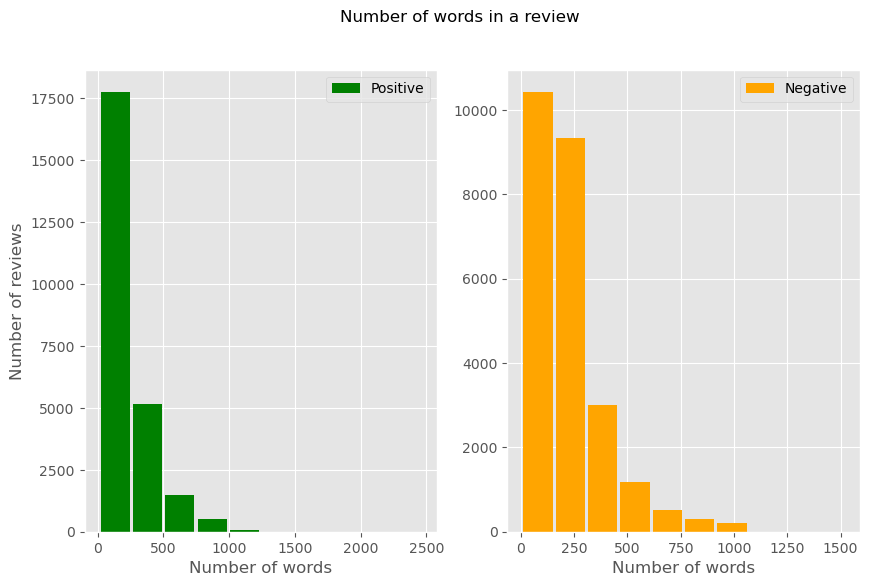

In [52]:
# plot the number of words in a review
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='green', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='orange', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in a review")
ax[0].set_xlabel("Number of words")
ax[0].set_ylabel("Number of reviews")
ax[1].set_xlabel("Number of words")
plt.show()

# Data Preprocessing and Cleaning

In [55]:
#Data cleaning
# Load stopwords
stop_words = set(stopwords.words('english'))

# Encode sentiment labels as numeric values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# Define the clean_text function to include stopword removal
def clean_text(text):
    # text = nlp(text)
    # text = str(text)
    text = re.sub('<br />', ' ', text)  # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
    # text = re.sub(r'[^a-zA-Z0-9' + r'\s]', ' ', text)
    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions like "don't" to "do not"
    # Remove stopwords
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in stopwords.words('english')])
    return text


In [57]:
# Apply the clean_text function to the reviews
df['review'] = df['review'].apply(clean_text)

In [58]:
# Check the first few rows after cleaning
df.head()

review  sentiment  word count
0  one reviewers mentioned watching oz episode ho...          1         307
1  wonderful little production filming technique ...          1         162
2  thought wonderful way spend time hot summer we...          1         166
3  basically family little boy jake thinks zombie...          0         138
4  petter matteis love time money visually stunni...          1         230

In [61]:
# check duplicates
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  421


In [63]:
# remove the duplicates
df = df.drop_duplicates('review')
# df.head()

In [65]:
# !pip install pyspellchecker  # Install the pyspellchecker package which contains SpellChecker

In [67]:
# # Spelling Correction
# from spellchecker import SpellChecker

# def correct_spelling(text):
#     spell = SpellChecker()
#     words = text.split()

#     corrected_words = []

#     for word in words:
#         corrected = spell.correction(word)
#         # If correction is None, use the original word
#         corrected_words.append(corrected if corrected else word)

#     return " ".join(corrected_words)


In [69]:
# # Apply spelling correction
# df['review'] = df['review'].apply(correct_spelling)

In [71]:
from nltk.stem import PorterStemmer

# Initialize stemmer
stemmer = PorterStemmer()

# Define function
def stemming(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

In [73]:
# apply to the 'review' column
df['stemmed_review'] = df['review'].apply(stemming)

In [74]:
# check the word count again
df['word count'] = df['review'].apply(word_count)
df.head()

review  sentiment  word count  \
0  one reviewers mentioned watching oz episode ho...          1         161   
1  wonderful little production filming technique ...          1          84   
2  thought wonderful way spend time hot summer we...          1          84   
3  basically family little boy jake thinks zombie...          0          64   
4  petter matteis love time money visually stunni...          1         125   

                                      stemmed_review  
0  one review mention watch oz episod hook right ...  
1  wonder littl product film techniqu unassum old...  
2  thought wonder way spend time hot summer weeke...  
3  basic famili littl boy jake think zombi closet...  
4  petter mattei love time money visual stun film...

In [77]:
# show pisitive reviews only
pos_reviews =  df[df.sentiment == 1]
pos_reviews.head()

review  sentiment  word count  \
0  one reviewers mentioned watching oz episode ho...          1         161   
1  wonderful little production filming technique ...          1          84   
2  thought wonderful way spend time hot summer we...          1          84   
4  petter matteis love time money visually stunni...          1         125   
5  probably alltime favorite movie story selfless...          1          54   

                                      stemmed_review  
0  one review mention watch oz episod hook right ...  
1  wonder littl product film techniqu unassum old...  
2  thought wonder way spend time hot summer weeke...  
4  petter mattei love time money visual stun film...  
5  probabl alltim favorit movi stori selfless sac...

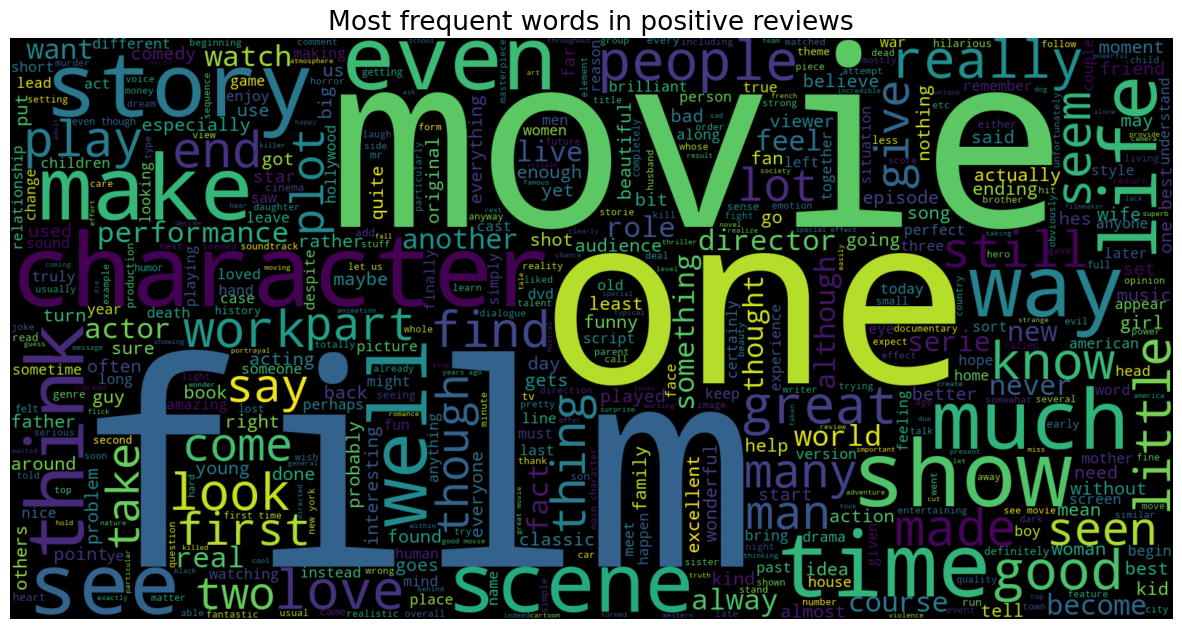

In [79]:
# Combine reviews into a single string directly using .str.cat
text = pos_reviews['review'].str.cat(sep=' ')

# Create and display the word cloud
plt.figure(figsize=(15, 10), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize=19)
plt.show()

In [80]:
# Flatten all words from reviews into a single list
all_words = [word for text in pos_reviews['review'].values for word in text.split()]

# Count word frequencies
count = Counter(all_words)

# Get the 20 most common words
most_common_words = count.most_common(20)

# Convert to DataFrame for table format
df_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Display the table
print(df_common_words)

      Word  Frequency
0     film      40027
1    movie      36516
2      one      26183
3     like      17122
4     good      14508
5    great      12736
6    story      12576
7     time      12082
8    would      11940
9      see      11936
10    well      11364
11    also      10696
12  really      10684
13    even       9440
14    much       9071
15   first       8942
16   films       8562
17    love       8472
18  people       8450
19    best       8358


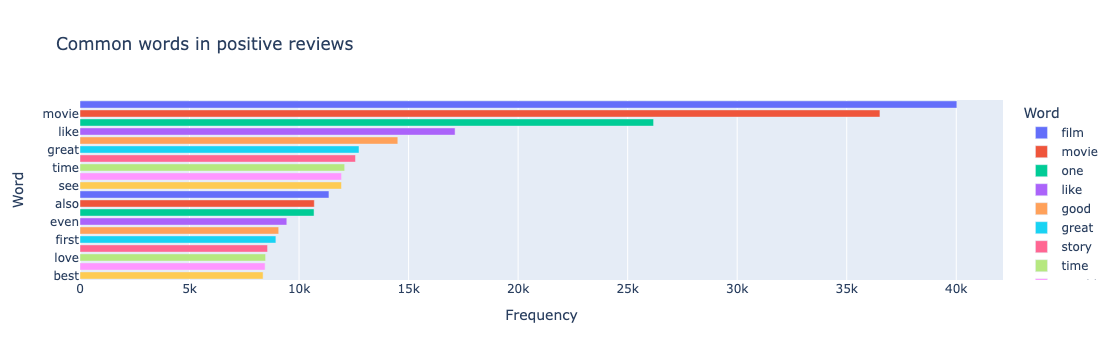

In [83]:
# Create an interactive bar chart using to visualize the most common words in positive reviews
pos_words = df_common_words
px.bar(
    pos_words,
    x='Frequency',
    y='Word',
    title='Common words in positive reviews',
    color='Word'
)

In [85]:
# show negative reviews only
neg_reviews =  df[df.sentiment == 0]
neg_reviews.head()

review  sentiment  word count  \
3   basically family little boy jake thinks zombie...          0          64   
7   show amazing fresh innovative idea first aired...          0          77   
8   encouraged positive comments film looking forw...          0          62   
10  phil alien one quirky films humour based aroun...          0          49   
11  saw movie came recall scariest scene big bird ...          0          81   

                                       stemmed_review  
3   basic famili littl boy jake think zombi closet...  
7   show amaz fresh innov idea first air first yea...  
8   encourag posit comment film look forward watch...  
10  phil alien one quirki film humour base around ...  
11  saw movi came recal scariest scene big bird ea...

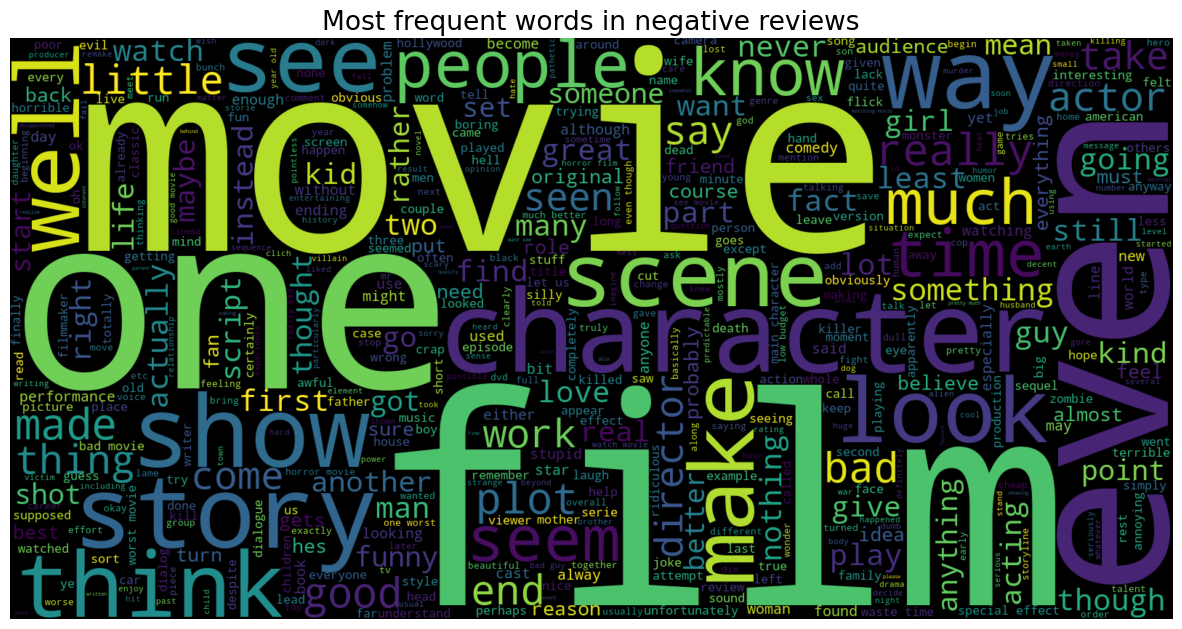

In [87]:
# Combine reviews into a single string directly using .str.cat
text = neg_reviews['review'].str.cat(sep=' ')

# Create and display the word cloud
plt.figure(figsize=(15, 10), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize=19)
plt.show()

In [89]:
# Flatten all words from reviews into a single list
all_words1 = [word for text in neg_reviews['review'].values for word in text.split()]

# Count word frequencies
count1 = Counter(all_words1)

# Get the 20 most common words
most_common_words1 = count1.most_common(20)

# Convert to DataFrame for table format
df_common_words1 = pd.DataFrame(most_common_words1, columns=['Word', 'Frequency'])

# Display the table
print(df_common_words1)

      Word  Frequency
0    movie      48030
1     film      35472
2      one      24904
3     like      21621
4    would      16187
5     even      14938
6      bad      14210
7     good      14193
8   really      12156
9     time      11692
10   could      11245
11     see      10501
12     get       9920
13    much       9872
14   story       9797
15  people       9117
16    make       8928
17  movies       8436
18    made       8380
19   first       8112


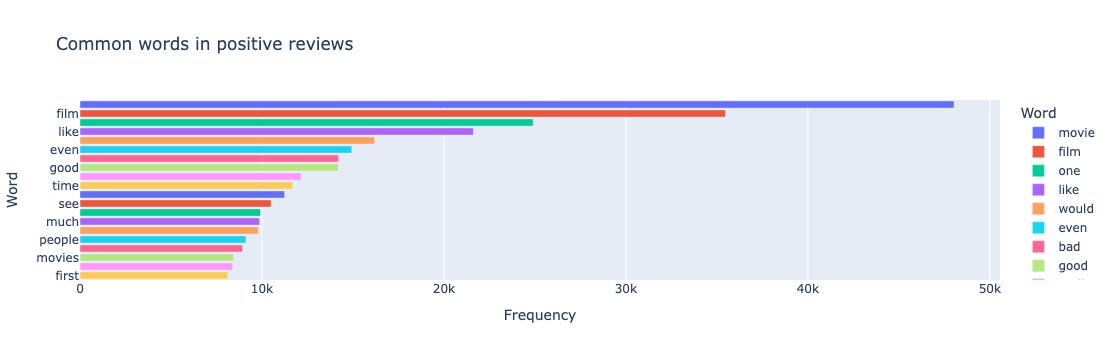

In [91]:
# Create an interactive bar chart using to visualize the most common words in negative reviews
neg_words = df_common_words1
px.bar(
    neg_words,
    x='Frequency',
    y='Word',
    title='Common words in positive reviews',
    color='Word'
)

# Model Building

In [94]:
# target and feature
X = df['review']
y = df['sentiment']

# feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shape of the split data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (39660, 161837)
Shape of X_test: (9915, 161837)
Shape of y_train: (39660,)
Shape of y_test: (9915,)


In [96]:
# # initialiaze all the models that we'll use
# models = {
#     'Logistic Regression': LogisticRegression(),
#     'Naive Bayes': MultinomialNB(),
#     'Support Vector Machine': SVC(),
#     'XGBoost': XGBClassifier()
# }

# # create a function that fits and predicts the models and checks for the accuracy, confusion matrix and classification report
# def model_fit(X_train, X_test, y_train, y_test, models):
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         conf_matrix = confusion_matrix(y_test, y_pred)
#         class_report = classification_report(y_test, y_pred)
#         print(f"\033[1mModel: {name}\033[0m")
#         print("-"*30)
#         print(f"\033[1mAccuracy: {accuracy}\033[0m")
#         print("-"*30)
#         print(f"Classification Report:\n{class_report}")
#         print("="*50)
#         print()

#         # Plot the confusion matrix
#         sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
#         plt.title(f'Confusion Matrix - {name}')
#         plt.show()
#         print("="*100)
#         print()

# # call the function
# model_fit(X_train, X_test, y_train, y_test, models)

Logistic Regression
--------------------------------------------------
Accuracy: 0.896
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4872
           1       0.89      0.91      0.90      5043

    accuracy                           0.90      9915
   macro avg       0.90      0.90      0.90      9915
weighted avg       0.90      0.90      0.90      9915



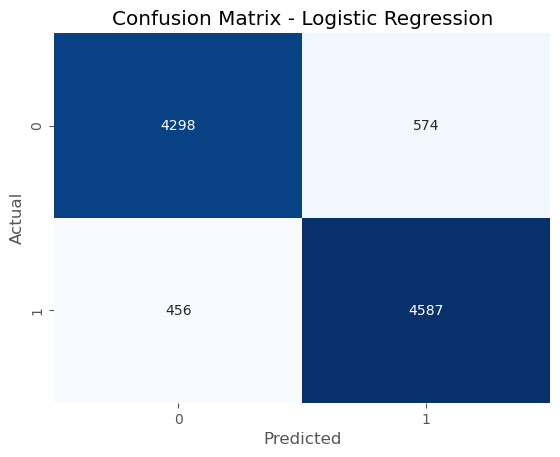

In [98]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

# Accuracy
accuracy_log = round(accuracy_score(y_test, y_pred_log), 3)
print("\033[1mLogistic Regression\033[0m")
print("-" * 50)
print(f"Accuracy: {accuracy_log}")
print("-" * 50)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_log))
print('='*80)

# Confusion Matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Naive Bayes
------------------------------
Accuracy: 0.869
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4872
           1       0.88      0.86      0.87      5043

    accuracy                           0.87      9915
   macro avg       0.87      0.87      0.87      9915
weighted avg       0.87      0.87      0.87      9915



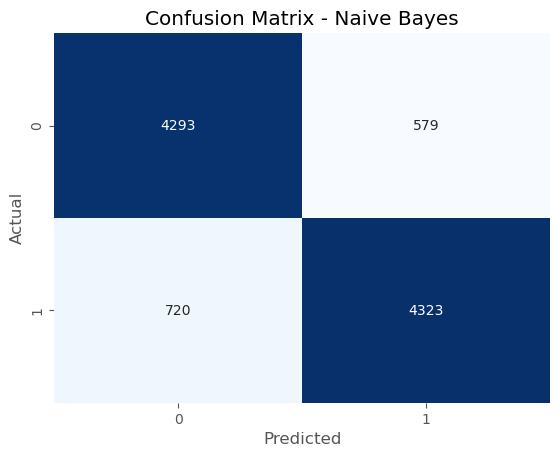

In [100]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

y_pred_nb = naive_bayes.predict(X_test)

# Accuracy
accuracy_nb = round(accuracy_score(y_test, y_pred_nb),3)
print("\033[1mNaive Bayes\033[0m")
print("-" * 30)
print(f"Accuracy: {accuracy_nb}")
print("-" * 30)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print('='*80)

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


Support Vector Machine
------------------------------
Accuracy: 0.901
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4872
           1       0.89      0.92      0.90      5043

    accuracy                           0.90      9915
   macro avg       0.90      0.90      0.90      9915
weighted avg       0.90      0.90      0.90      9915



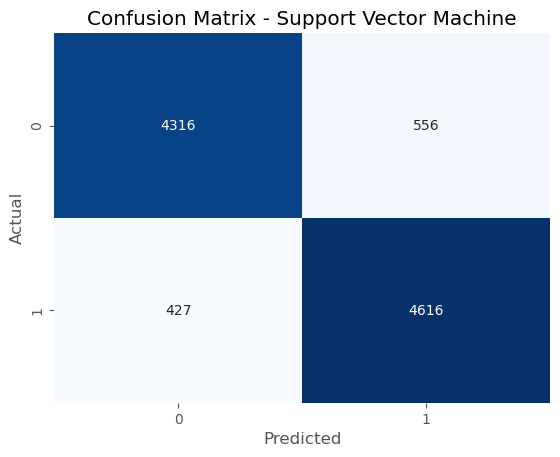

In [102]:
# Support Vector Machine
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

# Accuracy
accuracy_svc = round(accuracy_score(y_test, y_pred_svc),3)
print("\033[1mSupport Vector Machine\033[0m")
print("-" * 30)
print(f"Accuracy: {accuracy_svc}")
print("-" * 30)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_svc))
print('='*80)

# Confusion Matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine')
plt.show()


XGBoost
------------------------------
Accuracy: 0.856
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4872
           1       0.84      0.88      0.86      5043

    accuracy                           0.86      9915
   macro avg       0.86      0.86      0.86      9915
weighted avg       0.86      0.86      0.86      9915



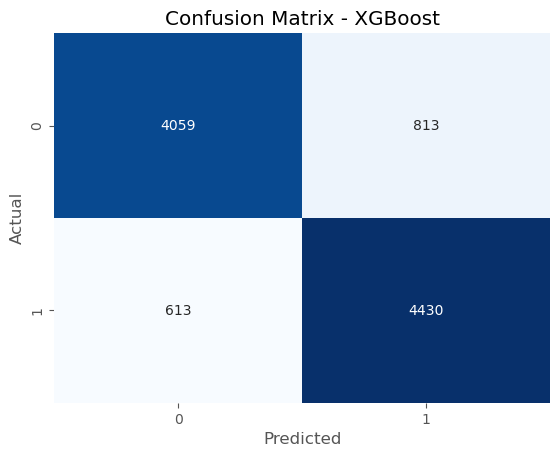

In [103]:
# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
accuracy_xgb = round(accuracy_score(y_test, y_pred_xgb),3)
print("\033[1mXGBoost\033[0m")
print("-" * 30)
print(f"Accuracy: {accuracy_xgb}")
print("-" * 30)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print('='*80)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


# Hyperparamer Tuning and Cross Validation

Best Hyperparameters for Logistic Regression: {'C': 10, 'max_iter': 100, 'solver': 'saga'}
Best Cross-Validation Score for Logistic Regression: 0.89
Test Set Accuracy for Logistic Regression: 0.90
--------------------------------------------------
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4872
           1       0.89      0.91      0.90      5043

    accuracy                           0.90      9915
   macro avg       0.90      0.90      0.90      9915
weighted avg       0.90      0.90      0.90      9915



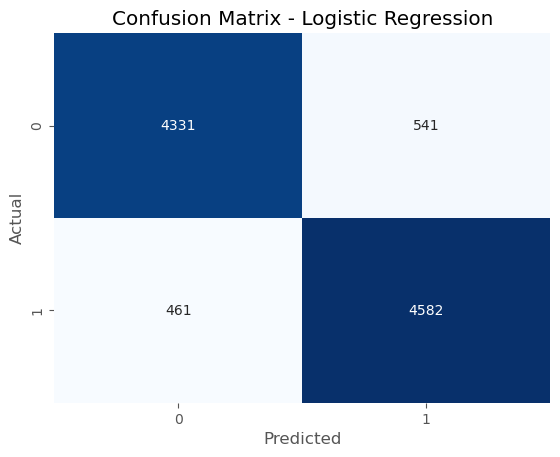

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


# Logistic Regression

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200]  # Maximum number of iterations
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Perform Grid Search with cross-validation
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and best score
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

# Output the results
print(f"Best Hyperparameters for Logistic Regression: {best_params_lr}")
print(f"Best Cross-Validation Score for Logistic Regression: {best_score_lr:.2f}")
print('='*50)

# Use the best model to predict
best_model_lr = grid_search_lr.best_estimator_

# Predict on the test set
y_pred_lr = best_model_lr.predict(X_test)

# Get accuracy score
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Test Set Accuracy for Logistic Regression: {accuracy_lr:.2f}")
print('-'*50)

# Classification Report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print('='*80)

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()





Best Hyperparameters for Naive Bayes: {'alpha': 1, 'fit_prior': False}
Best Cross-Validation Score for Naive Bayes: 0.87
Test Set Accuracy: 0.87
--------------------------------------------------
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4872
           1       0.88      0.86      0.87      5043

    accuracy                           0.87      9915
   macro avg       0.87      0.87      0.87      9915
weighted avg       0.87      0.87      0.87      9915



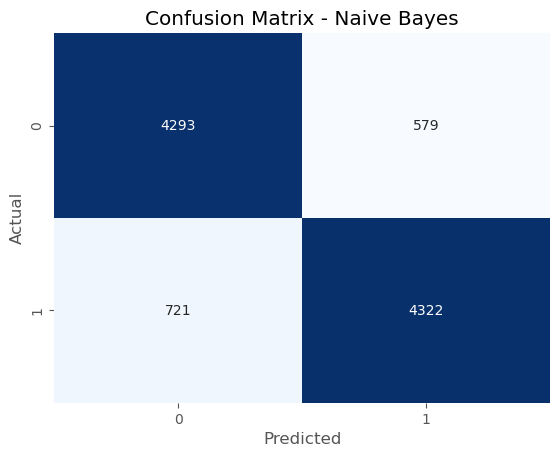

In [106]:
# Naive Bayes

# Define the parameter grid
param_grid_nb = {
    'alpha': [0.1, 0.5, 1, 10],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Perform Grid Search with cross-validation
grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_nb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_nb = grid_search_nb.best_params_
best_score_nb = grid_search_nb.best_score_

# Output the results
print(f"Best Hyperparameters for Naive Bayes: {best_params_nb}")
print(f"Best Cross-Validation Score for Naive Bayes: {best_score_nb:.2f}")
print('='*50)

# Use the best model to predict
best_model_nb = grid_search_nb.best_estimator_

# Predict on the test set
y_pred_nb = best_model_nb.predict(X_test)

# Get accuracy score
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Test Set Accuracy: {accuracy_nb:.2f}")
print('-'*50)

# Classification Report
print("Classification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print('='*80)

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


Best Hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score for SVM: 0.90
Test Set Accuracy for SVM: 0.90
--------------------------------------------------
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4872
           1       0.90      0.91      0.91      5043

    accuracy                           0.90      9915
   macro avg       0.90      0.90      0.90      9915
weighted avg       0.90      0.90      0.90      9915



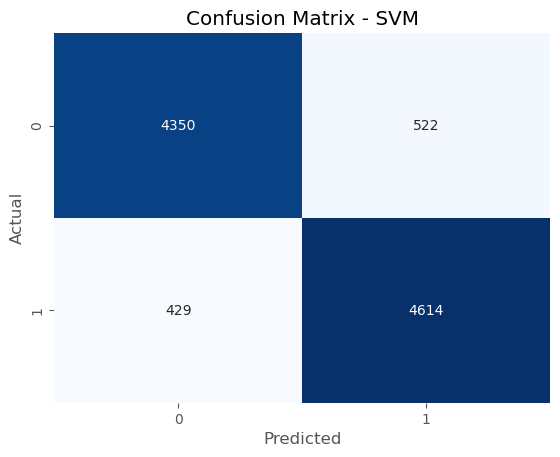

In [107]:
# # Support Vector Machine

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize the SVM model
svm_model = SVC()

# Perform Grid Search with cross-validation
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_svm.fit(X_train, y_train)

# Get the best parameters and best score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Output the results
print(f"Best Hyperparameters for SVM: {best_params_svm}")
print(f"Best Cross-Validation Score for SVM: {best_score_svm:.2f}")
print('='*50)

# Use the best model to predict
best_model_svm = grid_search_svm.best_estimator_

# Predict on the test set
y_pred_svm = best_model_svm.predict(X_test)

# Get accuracy score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Set Accuracy for SVM: {accuracy_svm:.2f}")
print('-'*50)

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))
print('='*80)

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()



Best Hyperparameters for XGBoost: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score for XGBoost: 0.86
Test Set Accuracy for XGBoost: 0.87
--------------------------------------------------
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4872
           1       0.86      0.88      0.87      5043

    accuracy                           0.87      9915
   macro avg       0.87      0.87      0.87      9915
weighted avg       0.87      0.87      0.87      9915



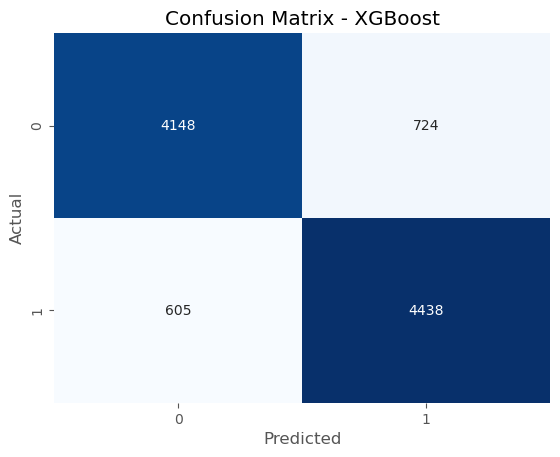

In [108]:
# XGB

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinking
    'n_estimators': [50, 100, 200],  # Number of trees in the ensemble
    'max_depth': [3, 6, 9],  # Maximum depth of the tree
    'subsample': [0.8, 1],  # Fraction of samples used for fitting each tree
    'colsample_bytree': [0.8, 1]  # Fraction of features used for fitting each tree
}

# Initialize the XGBoost model
xgb_model = XGBClassifier()

# Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

# Output the results
print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")
print(f"Best Cross-Validation Score for XGBoost: {best_score_xgb:.2f}")
print('='*50)

# Use the best model to predict
best_model_xgb = grid_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = best_model_xgb.predict(X_test)

# Get accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Test Set Accuracy for XGBoost: {accuracy_xgb:.2f}")
print('-'*50)

# Classification Report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print('='*80)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

